# Sistema de recomendação por similaridade para jogos

O dataset pode ser baixado no link a seguir

https://drive.google.com/file/d/1LBJbmtqkg5-KCiUn8-ZPsC6qAf-qM8hi/view?usp=sharing



# Importação de bibliotecas e módulos

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import  SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Leitura do arquivo

In [2]:
games = pd.read_parquet('/content/steam_games.parquet')
games

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,None,nan
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,nan
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,nan
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,None,nan
4,None,None,Log Challenge,None,http://store.steampowered.com/app/773570/Log_C...,None,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,None,None,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32130,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"[Strategy, Indie, Casual, Simulation]",1.49,http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,False,773640,"Nikita ""Ghost_RUS""",None,nan
32131,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"[Strategy, Indie, Casual]",4.24,http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,False,733530,Sacada,None,nan
32132,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"[Indie, Simulation, Racing]",1.39,http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,False,610660,Laush Dmitriy Sergeevich,None,nan
32133,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",NaN,http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.99,False,658870,"xropi,stev3ns",1 user reviews,nan


# Limpeza e tratamento de dados

## Criando uma coluna com o ano a partir da coluna 'release_year' e convertendo o preço para valor real

In [3]:
def year(texto):
  if type(texto) == str and re.match('^\d{4}-\d{2}-\d{2}$',texto):
    return texto.split('-')[0]

def convert_price(price):
  try:
    return float(price)
  except:
    return float(0.0)
games['release_year'] = games['release_date'].apply(year)

games['price'] = games['price'].apply(convert_price)

games

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore,release_year
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,None,nan,2018
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",0.00,False,643980,Secret Level SRL,Mostly Positive,nan,2018
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",0.00,False,670290,Poolians.com,Mostly Positive,nan,2017
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,None,nan,2017
4,None,None,Log Challenge,None,http://store.steampowered.com/app/773570/Log_C...,None,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,None,None,nan,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32130,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"[Strategy, Indie, Casual, Simulation]",1.49,http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,False,773640,"Nikita ""Ghost_RUS""",None,nan,2018
32131,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"[Strategy, Indie, Casual]",4.24,http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,False,733530,Sacada,None,nan,2018
32132,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"[Indie, Simulation, Racing]",1.39,http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,False,610660,Laush Dmitriy Sergeevich,None,nan,2018
32133,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",NaN,http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.99,False,658870,"xropi,stev3ns",1 user reviews,nan,2017


## Transformando a coluna 'sentiment' em valores númericos

In [4]:
games['sentiment'].unique()
sentiment_map = {'Overwhelmingly Positive':4,'Very Positive':3,'Mostly Positive':2,
                 'Positive':1,'Mixed':0,'Negative':-1,'Mostly Negative':-2,'Very Negative':-3,
                 'Overwhelmingly Negative':-4}

games['sentiment'] = games['sentiment'].map(sentiment_map).fillna(0)

games['sentiment'].unique()


array([ 0.,  2.,  3.,  4., -3.,  1., -2., -1., -4.])

## Criando uma tabela com colunas binárias associadas aos atriutos das colunas 'tags' e 'specs', estas colunas serão úteis para avaliar a similaridade entre os itens

In [5]:
tags = games.set_index('id')
tags = pd.get_dummies(tags['tags'].explode()).groupby('id').max()
tags


,1980s,1990's,2.5D,2D,2D Fighter,360 Video,3D Platformer,3D Vision,4 Player Local,4X,...,Warhammer 40K,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports
id,,,,,,,,,,,,,,,,,,,,,
10,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1002,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
100400,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10090,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
100980,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9970,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
99700,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9980,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [6]:
specs = games.set_index('id')
specs = pd.get_dummies(specs['specs'].explode()).groupby('id').max()
specs

,Captions available,Co-op,Commentary available,Cross-Platform Multiplayer,Full controller support,Game demo,Gamepad,HTC Vive,In-App Purchases,Includes Source SDK,...,Steam Achievements,Steam Cloud,Steam Leaderboards,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Motion Controllers,Valve Anti-Cheat enabled,Windows Mixed Reality
id,,,,,,,,,,,,,,,,,,,,,
10,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1002,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
100400,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10090,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
100980,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9970,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
99700,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9980,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Criando uma tabela com as colunas 'id', 'price' e as colunas das tabelas 'tags' e 'specs', a qual serśa usada para avaliar a similaridade entre os itens

In [7]:
data = games[['id','price', 'sentiment','release_year']].set_index('id')
data = data.merge(tags,left_index=True,right_index=True)
data = data.merge(specs,left_index=True,right_index=True)
data



,price,sentiment,release_year,1980s,1990's,2.5D,2D,2D Fighter,360 Video,3D Platformer,...,Steam Achievements,Steam Cloud,Steam Leaderboards,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Motion Controllers,Valve Anti-Cheat enabled,Windows Mixed Reality
id,,,,,,,,,,,,,,,,,,,,,
761140,4.99,0.0,2018,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
643980,0.00,2.0,2018,False,False,False,True,False,False,False,...,True,False,False,True,False,False,False,False,False,False
670290,0.00,2.0,2017,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
767400,0.99,0.0,2017,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
773570,2.99,0.0,None,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773640,1.99,0.0,2018,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
733530,4.99,0.0,2018,False,False,False,False,False,False,False,...,True,True,True,False,False,False,False,False,False,False
610660,1.99,0.0,2018,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,False,False,False


## Aplicando label encoder nas colunas da tabela'data', exceto as três primeiras ('price', 'sentiment' e 'release_year'), que já são numéricas

In [8]:
colunas = list(data.columns)
colunas = colunas[3:381]

for col in colunas:
  le = LabelEncoder()
  data[col] = le.fit_transform(data[col])

data



,price,sentiment,release_year,1980s,1990's,2.5D,2D,2D Fighter,360 Video,3D Platformer,...,Steam Achievements,Steam Cloud,Steam Leaderboards,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Motion Controllers,Valve Anti-Cheat enabled,Windows Mixed Reality
id,,,,,,,,,,,,,,,,,,,,,
761140,4.99,0.0,2018,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
643980,0.00,2.0,2018,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0
670290,0.00,2.0,2017,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
767400,0.99,0.0,2017,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
773570,2.99,0.0,None,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773640,1.99,0.0,2018,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
733530,4.99,0.0,2018,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
610660,1.99,0.0,2018,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


## Montando um pipeline com tratamento de dados brancos e nulos e scaling das colunas

In [9]:
pipe = Pipeline([('imputer',SimpleImputer()),('scaler',MinMaxScaler())])
pipe.fit(data)
df_vectors = pd.DataFrame(pipe.transform(data),index = data.index,columns=data.columns)
df_vectors

,price,sentiment,release_year,1980s,1990's,2.5D,2D,2D Fighter,360 Video,3D Platformer,...,Steam Achievements,Steam Cloud,Steam Leaderboards,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Motion Controllers,Valve Anti-Cheat enabled,Windows Mixed Reality
id,,,,,,,,,,,,,,,,,,,,,
761140,0.006466,0.500,0.979592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
643980,0.000000,0.750,0.979592,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
670290,0.000000,0.750,0.959184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
767400,0.001283,0.500,0.959184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
773570,0.003875,0.500,0.905227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773640,0.002579,0.500,0.979592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
733530,0.006466,0.500,0.979592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
610660,0.002579,0.500,0.979592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# Construindo a matriz de similaridade entre os itens

In [10]:
sim_matrix = pd.DataFrame(cosine_similarity(df_vectors),index = data.index,columns=data.index)
sim_matrix

id,761140,643980,670290,767400,773570,772540,768800,768570,724910,770380,...,771810,767590,747320,769330,745400,773640,733530,610660,658870,681550
id,,,,,,,,,,,,,,,,,,,,,
761140,1.000000,0.307717,0.560226,0.686232,0.575004,0.468265,0.677157,0.719518,0.474187,0.677156,...,0.629151,0.547172,0.417196,0.764125,0.639335,0.861295,0.639337,0.583889,0.489282,0.496503
643980,0.307717,1.000000,0.404754,0.194039,0.186873,0.189849,0.288366,0.233837,0.174997,0.354891,...,0.255074,0.288368,0.354887,0.309796,0.272262,0.378709,0.335073,0.378709,0.257892,0.164003
670290,0.560226,0.404754,1.000000,0.410168,0.446055,0.280211,0.623778,0.451704,0.372614,0.426210,...,0.376482,0.426215,0.327424,0.595199,0.402411,0.560227,0.495677,0.454814,0.381200,0.387331
767400,0.686232,0.194039,0.410168,1.000000,0.544385,0.550341,0.489585,0.515791,0.556665,0.796568,...,0.739421,0.489587,0.336089,0.683699,0.752086,0.522439,0.462243,0.358645,0.437176,0.471460
773570,0.575004,0.186873,0.446055,0.544385,1.000000,0.281595,0.433947,0.460023,0.740476,0.538845,...,0.498959,0.538846,0.329046,0.606002,0.508752,0.463065,0.409711,0.351126,0.388144,0.626709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773640,0.861295,0.378709,0.560227,0.522439,0.463065,0.468264,0.677152,0.579442,0.474188,0.677151,...,0.479692,0.677155,0.547166,0.764118,0.639335,1.000000,0.762057,0.722592,0.606063,0.401007
733530,0.639337,0.335073,0.495677,0.462243,0.409711,0.315892,0.484131,0.388752,0.419551,0.599134,...,0.424427,0.714137,0.599132,0.676083,0.674253,0.762057,1.000000,0.516613,0.639562,0.439296
610660,0.583889,0.378709,0.454814,0.358645,0.351126,0.468264,0.677152,0.579442,0.323016,0.547170,...,0.479692,0.547173,0.547166,0.582601,0.516613,0.722592,0.516613,1.000000,0.489280,0.401007


# Criando uma função para achar os n ids mais semelhantes

In [11]:
def similar_ids(id:'id',n:'number of desired ids'):
 df = sim_matrix[str(id)].sort_values(ascending=False)
 return df[1:n+1]

In [12]:
similar_ids(773640,8)

,773640
id,
749710,0.999975
693890,0.999975
689180,0.999975
687480,0.999975
687490,0.999975
695590,0.999974
214100,0.999061
747810,0.936780


# Criando uma função para achar os n jogos mais recomendados para cada jogo

In [13]:
def recomended_games(id:'id',n:'number of desired products'):
  recom = games[['id','title','price','developer','release_year']]
  df = similar_ids(id,n).reset_index()
  recom = recom.merge(df,left_index=True,right_index=True,how='inner')
  recom = recom[['id_x', 'title', 'price', 'developer', 'release_year']]
  recom.columns = ['id', 'title', 'price', 'developer', 'release_year']
  return recom


In [14]:
display(games[['id','title']][games['title']=='Grand Theft Auto'])
recomended_games(773570,3)


,id,title
102,12170,Grand Theft Auto


,id,title,price,developer,release_year
0,761140,Lost Summoner Kitty,4.99,Kotoshiro,2018
1,643980,Ironbound,0.00,Secret Level SRL,2018
2,670290,Real Pool 3D - Poolians,0.00,Poolians.com,2017


# Repetindo o processo anteror usando o PCA no pipeline

In [15]:
n_components=data.shape[1]
pipepca = Pipeline([('imputer',SimpleImputer()),('scaler',MinMaxScaler()),
                    ('decomposition',PCA(n_components=n_components))])
pipepca.fit(data)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('decomposition', PCA(n_components=381))])

# Montando um gráfico da variância explicada para determinar o número de componentes ideal a ser utilizado a partir do PCA

In [16]:
def plot_explained_variance(explained_variance,figsize=(16,8),threshold=0.9,cumulative=True):
  label='Explained Variance'
  n_components=len(explained_variance)
  fig, axes = plt.subplots(nrows=2,figsize=figsize,sharex=True)

  ax = axes[0]
  ax.plot(explained_variance,label=label)

  ax.set_title(f'{label} ({n_components} components)')

  ax = axes[1]
  label = f'Cumulative {label}'
  ax.plot(np.cumsum(explained_variance),label=label)
  ax.axhline(threshold,c='black',linestyle="--",label="Threshold")
  ax.set_title(f'{label} ({n_components} components)')
  ax.set_xlabel('Principal Components')
  ax.set_ylim(top=1.0)
  ax.legend()
  [ax_i.grid(True,linestyle="--") for ax_i in axes]

  return fig,ax


(<Figure size 1200x800 with 2 Axes>,
 <Axes: title={'center': 'Cumulative Explained Variance (381 components)'}, xlabel='Principal Components'>)

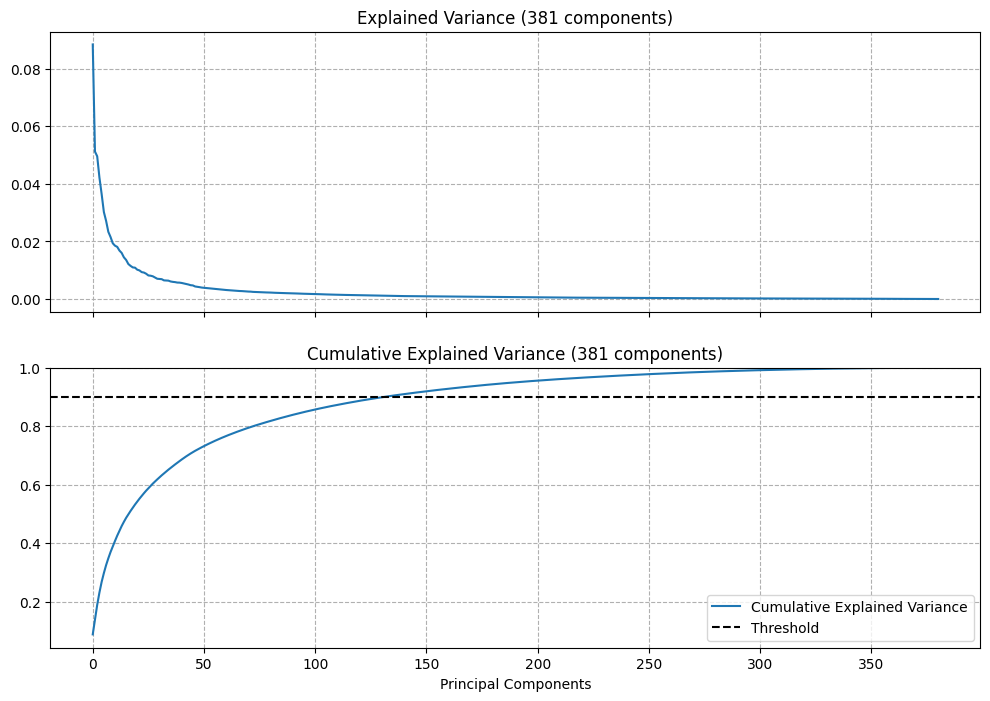

In [17]:
explained_variance_ratio = pipepca.named_steps['decomposition'].explained_variance_ratio_

plot_explained_variance(explained_variance_ratio,cumulative=False,figsize=(12,8))

# Redução de dimensionalidader

In [18]:
n_components = 150

pipepca = Pipeline([('imputer',SimpleImputer()),('scaler',MinMaxScaler()),
                    ('decomposition',PCA(n_components=n_components))])
pipepca.fit(data)

def generate_vector_representation(pipeline:Pipeline, preprocessed_data:pd.DataFrame, keep_columns=True):
    df_vectors = pd.DataFrame(pipepca.transform(preprocessed_data))
    if keep_columns:
        df_vectors.columns = preprocessed_data.columns
    df_vectors.index = preprocessed_data.index
    df_vectors.index.name = 'id'
    return df_vectors

df_vectors_pca = generate_vector_representation(pipepca, data,keep_columns=False)
df_vectors_pca

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
id,,,,,,,,,,,,,,,,,,,,,
761140,-0.522485,0.076401,-0.125253,-0.471542,0.429971,0.790884,0.387062,-0.749484,0.002842,-0.578743,...,0.008517,-0.001798,-0.006975,-0.004643,0.013299,-0.015256,-0.010519,-0.000171,-0.003666,-0.012443
643980,0.732308,-0.425952,0.331799,-0.547069,1.199079,0.031473,-0.964211,-0.138374,-0.727896,1.382244,...,0.178112,0.052518,0.540429,-0.211770,-0.156191,-0.029355,0.410843,0.068023,0.035406,-0.182800
670290,-0.520748,-0.017483,0.431517,-0.708508,1.011438,0.775600,0.587939,0.428515,-0.266247,0.156748,...,0.017106,-0.020491,0.077456,-0.045580,0.004900,0.017313,-0.014191,0.020312,0.003766,0.004364
767400,-0.549359,-0.232052,-0.100161,0.386239,-0.437533,0.568720,0.444532,0.438448,0.062738,-0.711775,...,0.014652,-0.011039,0.000764,0.000605,-0.003606,-0.017843,-0.027368,-0.001118,-0.013642,-0.018287
773570,-0.773685,1.506851,0.119465,-0.015891,-0.424752,0.154669,0.455386,-0.075107,-0.491817,-0.166919,...,-0.102573,0.066546,0.143616,0.146682,0.118077,-0.043784,0.063445,-0.095338,0.055061,0.046692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773640,-0.349463,0.068893,-0.676618,-0.601276,0.954593,0.353909,0.142393,-0.419434,0.036565,-0.400362,...,0.000361,0.005052,-0.009234,-0.004440,0.010811,-0.016645,-0.007928,0.002551,-0.009952,-0.008608
733530,0.174273,0.250383,-0.757592,-0.927149,0.689342,-0.188413,0.021640,0.032451,0.136873,-0.603830,...,-0.007993,0.011170,-0.005205,-0.014944,0.006827,-0.021753,-0.009098,0.013875,-0.026220,-0.010352
610660,-0.027339,0.029943,-0.537826,-0.515403,0.307041,-0.108235,-0.363797,-0.249267,0.432076,0.237075,...,0.012294,0.016311,-0.004184,0.004463,-0.003830,-0.006684,0.000319,0.004815,0.018312,-0.004817


In [19]:
# Construido a matriz de similaridade com as 150 componentes mais relevantes obtidas a partir do PCA

In [20]:
sim_matrix_pca = pd.DataFrame(cosine_similarity(df_vectors_pca),index = data.index,columns=data.index)
sim_matrix_pca

id,761140,643980,670290,767400,773570,772540,768800,768570,724910,770380,...,771810,767590,747320,769330,745400,773640,733530,610660,658870,681550
id,,,,,,,,,,,,,,,,,,,,,
761140,1.000000,-0.084845,0.244199,0.297848,0.213258,0.081826,0.379876,0.446543,0.103958,0.182135,...,0.160275,0.034122,-0.136246,0.419555,0.130536,0.682664,0.229718,0.093791,-0.031785,0.097133
643980,-0.084845,1.000000,0.195165,-0.287030,-0.165016,-0.140375,-0.036178,-0.142891,-0.153188,-0.039196,...,-0.183291,-0.081635,0.065404,-0.135584,-0.164089,0.039805,0.003290,0.059740,-0.097132,-0.165852
670290,0.244199,0.195165,1.000000,-0.016341,0.140448,-0.074176,0.406427,0.115829,0.077908,-0.073379,...,-0.092231,0.035068,-0.070827,0.279717,-0.085460,0.240892,0.154596,0.073869,-0.007162,0.072177
767400,0.297848,-0.287030,-0.016341,1.000000,0.158671,0.257991,0.040680,0.080688,0.313064,0.449684,...,0.432691,-0.067588,-0.252252,0.315873,0.365188,-0.066665,-0.136632,-0.351084,-0.126889,0.042262
773570,0.213258,-0.165016,0.140448,0.158671,1.000000,-0.123576,0.051427,0.076581,0.575932,0.081453,...,0.066598,0.177258,-0.127820,0.233706,0.050508,-0.009211,-0.057071,-0.183029,-0.053246,0.406471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773640,0.682664,0.039805,0.240892,-0.066665,-0.009211,0.076837,0.376524,0.158638,0.097624,0.174786,...,-0.188807,0.307500,0.115575,0.412107,0.123405,1.000000,0.489290,0.392160,0.203104,-0.087244
733530,0.229718,0.003290,0.154596,-0.136632,-0.057071,-0.169965,0.038393,-0.167156,0.020410,0.069187,...,-0.233806,0.422409,0.251065,0.246134,0.278501,0.489290,1.000000,0.002615,0.312594,0.036092
610660,0.093791,0.059740,0.073869,-0.351084,-0.183029,0.107280,0.395190,0.194599,-0.118483,-0.098440,...,-0.128841,0.068275,0.149009,0.060164,-0.118469,0.392160,0.002615,1.000000,-0.000627,-0.056044


# Definindi a função de cáluclo da similaridade entre os jogos

In [21]:
def similar_ids_pca(id:'id',n:'number of desired ids'):
 df = sim_matrix[str(id)].sort_values(ascending=False)
 return df[1:n+1]

In [22]:
similar_ids_pca(773640,8)

,773640
id,
749710,0.999975
693890,0.999975
689180,0.999975
687480,0.999975
687490,0.999975
695590,0.999974
214100,0.999061
747810,0.936780


# Definindo e aplicando a função de cálculo dos n jogos recvomendados com base no critério de similaridade

In [23]:
def recomended_games_pca(id:'id',n:'number of desired products'):
  recom = games[['id','title','price','developer','release_year']]
  df = similar_ids_pca(id,n).reset_index()
  recom = recom.merge(df,left_index=True,right_index=True,how='inner')
  recom = recom[['id_x', 'title', 'price', 'developer', 'release_year']]
  recom.columns = ['id', 'title', 'price', 'developer', 'release_year']
  return recom

In [24]:
display(games[['id','title']][games['title']=='Grand Theft Auto'])
recomended_games_pca(773570,3)

,id,title
102,12170,Grand Theft Auto


,id,title,price,developer,release_year
0,761140,Lost Summoner Kitty,4.99,Kotoshiro,2018
1,643980,Ironbound,0.00,Secret Level SRL,2018
2,670290,Real Pool 3D - Poolians,0.00,Poolians.com,2017


pipe = Pipeline([('Imputer',SimpleImputer),'Scaler',MinMaxScaler()])